In [ ]:
! pip install -qU langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph tavily-python

In [ ]:
import os

os.environ['TAVILY_API_KEY'] = 'your_tavily_api_key'
os.environ['OPENAI_API_KEY'] = 'your_openai_api_key'

# Corrective RAG (CRAG)

Corrective-RAG (CRAG) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents.

In the original paper, a few steps are taken:
* If at least one document exceeds the threshold for relevance, then it proceeds to generation
* Before generation, it performs knowledge refinement
* This partitions the document into "knowledge strips"
* It grades each strip, and filters our irrelevant ones
* If all documents fall below the relevance threshold or if the grader is unsure, then the framework seeks an additional datasource
* It will use web search to supplement retrieval

In our implementation:
* We skip the knowledge refinement phase as a first pass. This can be added back as a node, if desired.
* If any documents are irrelevant, we opt to supplement retreival with web search.
* We use Tavily search for web search
* We use query re-writing to optimize the query for web search.

# Create Index

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

# LLMs

In [4]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

# Data Model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with function call
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """
    You are a grader assessing relevance of a retrieved document to a user question. \n
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question.
"""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system),
        ('human', "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [5]:
# Test the retrieval grader
question = 'agent memory'
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(
    retrieval_grader.invoke(
        {'question': question, 'document': doc_txt}
    )
)

binary_score='yes'


In [6]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull('rlm/rag-prompt')

# LLM
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [7]:
# Test the generation
generation = rag_chain.invoke(
    {'context': docs, 'question': question}
)
print(generation)

The agent system overview includes components like planning, subgoal decomposition, reflection, and refinement. Generative agents combine LLM with memory, planning, and reflection mechanisms for behavior conditioned on past experiences. The memory stream module serves as a long-term memory database for recording agents' experiences.


In [8]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)

# Prompt
system = """
    You are a question re-writer that converts an input question to a better version that is optimized \n
for web search. Look at the input and try to reason about the underlying semantic intent / meaning
"""
rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system),
        (
            'human',
            'Here is the initial question: \n\n {question} \n Formulate an improved question.',
        ),
    ]
)

question_rewriter = rewrite_prompt | llm | StrOutputParser()

In [9]:
print(f"Orignal question: {question}")
print(f"Re-written question: {question_rewriter.invoke({'question': question})}")

Orignal question: agent memory
Re-written question: What is the role of memory in artificial intelligence agents?


# Web Search Tool

In [10]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

# Create Graph

## Define Graph State

In [11]:
from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """Represent the state of our graph

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [18]:
from langchain.schema import Document


def retrieve(state):
    """Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print('--- RETRIEVE ---')
    question = state['question']

    # Retrival
    documents = retriever.invoke(question)
    return {
        'documents': documents,
        'question': question,
    }


def generate(state):
    """Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print('--- GENERATE ---')
    question = state['question']
    documents = state['documents']

    # RAG generation
    generation = rag_chain.invoke(
        {'context': documents, 'question': question}
    )

    return {
        'documents': documents,
        'question': question,
        'generation': generation,
    }


def grade_documents(state):
    """Determine whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Update document key with only filtered relevant documents
    """
    print('--- CHECK DOCUMENT RELEVANCE TO QUESTION ---')
    question = state['question']
    documents = state['documents']

    # Score each document
    filtered_docs = []
    web_search = 'no'
    for doc in documents:
        score = retrieval_grader.invoke(
            {'question': question, 'document': doc.page_content}
        )
        grade = score.binary_score
        if grade == 'yes':
            print('--- GRADE: DOCUMENT RELEVANT ---')
            filtered_docs.append(doc)
        else:
            print('--- GRADE: DOCUMENT NOT RELEVANT ---')
            web_search = 'yes'
            continue

    return {
        'documents': filtered_docs,
        'question': question,
        'web_search': web_search,
    }


def transform_query(state):
    """Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Update question key with re-written question
    """
    print('--- TRANSFORM QUERY ---')
    question = state['question']
    documents = state['documents']

    # Re-write question
    better_question = question_rewriter.invoke({'question': question})

    return {
        'documents': documents,
        'question': better_question,
    }


def web_search(state):
    """Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Update documents key with appended web results
    """
    print('--- WEB SEARCH ---')
    question = state['question']
    documents = state['documents']

    # Web search
    docs = web_search_tool.invoke({'query': question})
    web_results = "\n".join([doc['content'] for doc in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {
        'documents': documents,
        'question': question,
    }

In [19]:
### Edges

def decide_to_generate(state):
    """Determine whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: binary decision for next node to call
    """
    print('--- ASSESS GRADED DOCUMENTS ---')
    question = state['question']
    web_search = state['web_search']
    documents = state['documents']

    if web_search == 'yes':
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "--- DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY ---"
        )
        return 'transform_query'
    else:
        # We have relevant documents, so generate answer
        print("--- DECISION: GENERATE ---")
        return 'generate'

## Compile Graph

In [20]:
from langgraph.graph import START, END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node('retrieve', retrieve) # retrieve
workflow.add_node('grade_documents', grade_documents) # check relevance
workflow.add_node('transform_query', transform_query) # re-write query
workflow.add_node('web_search_node', web_search) # web search
workflow.add_node('generate', generate) # generate

# Build graph
workflow.add_edge(START, 'retrieve')
workflow.add_edge('retrieve', 'grade_documents')
workflow.add_conditional_edges(
    'grade_documents',
    decide_to_generate,
    {
        'transform_query': 'transform_query',
        'generate': 'generate',
    }
)
workflow.add_edge('transform_query', 'web_search_node')
workflow.add_edge('web_search_node', 'generate')
workflow.add_edge('generate', END)

# Compile
app = workflow.compile()

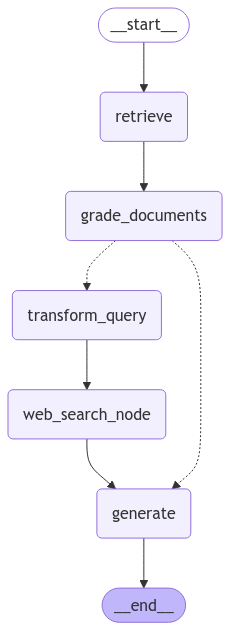

In [21]:
from IPython.display import Image, display

display(Image(
    app.get_graph(xray=True).draw_mermaid_png()
))

# Use the graph

In [22]:
from pprint import pprint

# Run
inputs = {'question': "what are the types of agent memory?"}

for output in app.stream(inputs):
    for key, val in output.items():
        pprint(f"Node '{key}':")
        pprint(val, indent=2, width=80, depth=None)
    pprint('\n---\n')

# Final generation
pprint(val['generation'])

--- RETRIEVE ---
"Node 'retrieve':"
{ 'documents': [ Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"}, page_content='Fig. 7. Comparison of AD, ED, source policy and RL^2 on environments that require memory and exploration. Only binary reward is assigned. The source policies are trained with A3C for "dark" environments and DQN for watermaze.(Image source: Laskin et al. 2023)\nCompon

In [23]:
# Run
inputs = {'question': "How does the AlphaCodium paper work?"}

for output in app.stream(inputs):
    for key, val in output.items():
        pprint(f"Node '{key}':")
        pprint(val, indent=2, width=80, depth=None)
    pprint('\n---\n')

# Final generation
pprint(val['generation'])

--- RETRIEVE ---
"Node 'retrieve':"
{ 'documents': [ Document(metadata={'description': 'The use of large language models in the real world has strongly accelerated by the launch of ChatGPT. We (including my team at OpenAI, shoutout to them) have invested a lot of effort to build default safe behavior into the model during the alignment process (e.g. via RLHF). However, adversarial attacks or jailbreak prompts could potentially trigger the model to output something undesired.\nA large body of ground work on adversarial attacks is on images, and differently it operates in the continuous, high-dimensional space.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/', 'title': "Adversarial Attacks on LLMs | Lil'Log"}, page_content='Fig. 12. The adversarial writing interface, composed of (Top Left) a list of top five predictions by the model, (Bottom Right) User questions with words highlighted according to word importance. (Image source: Wallace et al